### Analysis of Sleep, Recovery, and Training Load Data

This project explores the relationship between sleep, recovery, and training load using anonymous data from Oura and Strava wearable devices. No additional information about the user was provided.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_axes_aligner import align
from scipy.stats import pearsonr
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

Three separate datasets are cleaned and joined to make the full dataset. The oura_activity file is used to remove entries where the user wore the ring less than 18 hours per day. The oura_sleep file contains data for time spent in various stages of sleep and the users daily heart rate variability (HRV) measurement. Oura uses the Root Mean Square of Successive Differences between normal heartbeats (RMSSD) to monitor HRV.

In [2]:
# load the data
oura_activity = pd.read_csv('oura_activity.csv')
oura_sleep = pd.read_csv('oura_sleep.csv')
strava_activity = pd.read_excel('strava_activity.xlsx')

In [3]:
# inspect the oura activity data
oura_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      531 non-null    object
 1   non_wear  531 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.4+ KB


In [4]:
# inspect the oura sleep data
oura_sleep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487 entries, 0 to 486
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 487 non-null    object 
 1   awake                487 non-null    int64  
 2   light                487 non-null    int64  
 3   rem                  487 non-null    int64  
 4   deep                 487 non-null    int64  
 5   rmssd                486 non-null    float64
 6   bedtime_start_delta  487 non-null    int64  
 7   bedtime_end_delta    487 non-null    int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 30.6+ KB


Note the large number of missing entries for RPE.

In [5]:
# inspect the strava activity data
strava_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           314 non-null    object 
 1   activity_type  314 non-null    object 
 2   elapsed_time   314 non-null    int64  
 3   distance       314 non-null    float64
 4   max_hr         263 non-null    float64
 5   max_grade      308 non-null    float64
 6   max_speed      308 non-null    float64
 7   rpe            193 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 19.8+ KB


Clean the Strava data.

In [6]:
# convert the date column to actual date datatype
strava_activity.date = pd.to_datetime(strava_activity.date.apply(lambda x: "".join(x.split(',')[:2])))
strava_activity.date = strava_activity.date.dt.date

# drop workout, yoga, walk, rowing, and roller ski from strava dataset
strava_activity = strava_activity.loc[strava_activity.activity_type != "Workout", :]
strava_activity = strava_activity.loc[strava_activity.activity_type != "Yoga", :]
strava_activity = strava_activity.loc[strava_activity.activity_type != "Walk", :]
strava_activity = strava_activity.loc[strava_activity.activity_type != "Rowing", :]
strava_activity = strava_activity.loc[strava_activity.activity_type != "Roller Ski", :]

# convert activity type to lower case and replace spaces with underscores
strava_activity.activity_type = strava_activity.activity_type.str.lower().str.replace(' ', '_')

# convert swim distance from m to km
strava_activity.loc[strava_activity.activity_type == "swim", "distance"] = (strava_activity.loc[strava_activity.activity_type == "swim", "distance"] / 1000)

# add columns for total time and total distance
strava_activity["total_time"] = strava_activity.elapsed_time.groupby(strava_activity.date).transform('sum')
strava_activity["total_dist"] = strava_activity.distance.groupby(strava_activity.date).transform('sum')

# overwrite the max_hr, max_grade, max_speed, and rpe columns with the max results for that date
strava_activity.max_hr = strava_activity.max_hr.groupby(strava_activity.date).transform('max').round()
strava_activity.max_grade = strava_activity.max_grade.groupby(strava_activity.date).transform('max').round(1)
strava_activity.max_speed = strava_activity.max_speed.groupby(strava_activity.date).transform('max').round(1)
strava_activity.rpe = strava_activity.rpe.groupby(strava_activity.date).transform('max').round()

# use activity_type to create dummy variables
strava_activity = pd.concat([strava_activity, pd.get_dummies(strava_activity.activity_type)], axis=1)

# sum the activities by date so each entry represents the number of rides, runs, etc, per day
strava_activity.hike = strava_activity.hike.groupby(strava_activity.date).transform('sum')
strava_activity.ride = strava_activity.ride.groupby(strava_activity.date).transform('sum')
strava_activity.run = strava_activity.run.groupby(strava_activity.date).transform('sum')
strava_activity.swim = strava_activity.swim.groupby(strava_activity.date).transform('sum')
strava_activity.virtual_ride = strava_activity.virtual_ride.groupby(strava_activity.date).transform('sum')
strava_activity.virtual_run = strava_activity.virtual_run.groupby(strava_activity.date).transform('sum')

# remove redundant columns and drop duplicate rows
strava_activity = strava_activity.drop(columns=['activity_type', 'elapsed_time', 'distance'])
strava_activity = strava_activity.drop_duplicates(ignore_index=True)

# convert time from seconds to hours
strava_activity.total_time = ((strava_activity.total_time / 60) / 60).round(2)

In [7]:
# view clean data
strava_activity.head()

,date,max_hr,max_grade,max_speed,rpe,total_time,total_dist,hike,ride,run,swim,virtual_ride,virtual_run
0,2020-06-23,NaN,20.6,18.3,7.0,1.17,21.34,0,0,0,0,1,0
1,2020-06-24,NaN,6.5,15.8,NaN,0.75,23.31,0,0,0,0,1,0
2,2020-06-25,NaN,12.0,21.9,9.0,1.32,33.03,0,0,0,0,1,0
3,2020-06-27,NaN,15.8,20.4,9.0,2.55,47.85,0,0,0,0,2,0
4,2020-06-28,NaN,7.6,16.4,8.0,1.06,34.07,0,0,0,0,1,0


In [8]:
strava_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          227 non-null    object 
 1   max_hr        190 non-null    float64
 2   max_grade     224 non-null    float64
 3   max_speed     224 non-null    float64
 4   rpe           154 non-null    float64
 5   total_time    227 non-null    float64
 6   total_dist    227 non-null    float64
 7   hike          227 non-null    uint8  
 8   ride          227 non-null    uint8  
 9   run           227 non-null    uint8  
 10  swim          227 non-null    uint8  
 11  virtual_ride  227 non-null    uint8  
 12  virtual_run   227 non-null    uint8  
dtypes: float64(6), object(1), uint8(6)
memory usage: 13.9+ KB


Clean the Oura data.

In [9]:
# join the oura tables
oura = pd.merge(oura_sleep, oura_activity, how='left', on='date')

# drop dates where ring was worn less than 18 hours
oura = oura.loc[~(oura.non_wear > 360), :]

# drop na values
oura = oura.dropna()

# convert time to hours
oura.awake = ((oura.awake / 60) / 60).round(2)
oura.light = ((oura.light / 60) / 60).round(2)
oura.rem = ((oura.rem / 60) / 60).round(2)
oura.deep = ((oura.deep / 60) / 60).round(2)
oura.bedtime_start_delta = ((oura.bedtime_start_delta / 60) / 60).round(2)
oura.bedtime_end_delta = ((oura.bedtime_end_delta / 60) / 60).round(2)

# create columns for bedtime, wake_time, and total_sleep
oura["bedtime"] = oura.bedtime_start_delta.apply(lambda x: 24 + x if x < 0 else (24 + x) % 24).round(1)
oura["wake_time"] = oura.bedtime_end_delta.apply(lambda x: (24 + x) % 24 if x > 0 else 24 + x).round(1)
oura["total_sleep"] = (oura.light + oura.rem + oura.deep)

# drop the bedtime_start_delta, bedtime_end_delta, non_wear columns and reset the index
oura = oura.drop(columns=['bedtime_start_delta', 'bedtime_end_delta', 'non_wear'])
oura = oura.reset_index(drop=True)

# convert the date column to actual date datatype
oura.date = pd.to_datetime(oura.date, dayfirst=True)
oura.date = oura.date.dt.date

In [10]:
# view clean data
oura.head()

,date,awake,light,rem,deep,rmssd,bedtime,wake_time,total_sleep
0,2020-06-25,0.54,4.08,0.87,2.31,56.0,23.1,6.9,7.26
1,2020-06-26,0.46,3.55,1.25,1.84,54.0,0.0,7.1,6.64
2,2020-06-27,1.01,4.91,1.82,2.47,67.0,23.2,9.4,9.20
3,2020-06-28,0.57,3.36,1.54,2.15,57.0,23.4,7.1,7.05
4,2020-06-29,0.73,3.46,1.18,2.46,64.0,22.8,6.6,7.10


In [11]:
oura.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 448 entries, 0 to 447
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         448 non-null    object 
 1   awake        448 non-null    float64
 2   light        448 non-null    float64
 3   rem          448 non-null    float64
 4   deep         448 non-null    float64
 5   rmssd        448 non-null    float64
 6   bedtime      448 non-null    float64
 7   wake_time    448 non-null    float64
 8   total_sleep  448 non-null    float64
dtypes: float64(8), object(1)
memory usage: 31.6+ KB


Combine the Oura and Strava data.

In [12]:
# join the two dataframes
combined_data = pd.merge(strava_activity, oura, how='inner', on='date')

In [13]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 0 to 181
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          182 non-null    object 
 1   max_hr        151 non-null    float64
 2   max_grade     179 non-null    float64
 3   max_speed     179 non-null    float64
 4   rpe           123 non-null    float64
 5   total_time    182 non-null    float64
 6   total_dist    182 non-null    float64
 7   hike          182 non-null    uint8  
 8   ride          182 non-null    uint8  
 9   run           182 non-null    uint8  
 10  swim          182 non-null    uint8  
 11  virtual_ride  182 non-null    uint8  
 12  virtual_run   182 non-null    uint8  
 13  awake         182 non-null    float64
 14  light         182 non-null    float64
 15  rem           182 non-null    float64
 16  deep          182 non-null    float64
 17  rmssd         182 non-null    float64
 18  bedtime       182 non-null    

Exploratory data analysis.

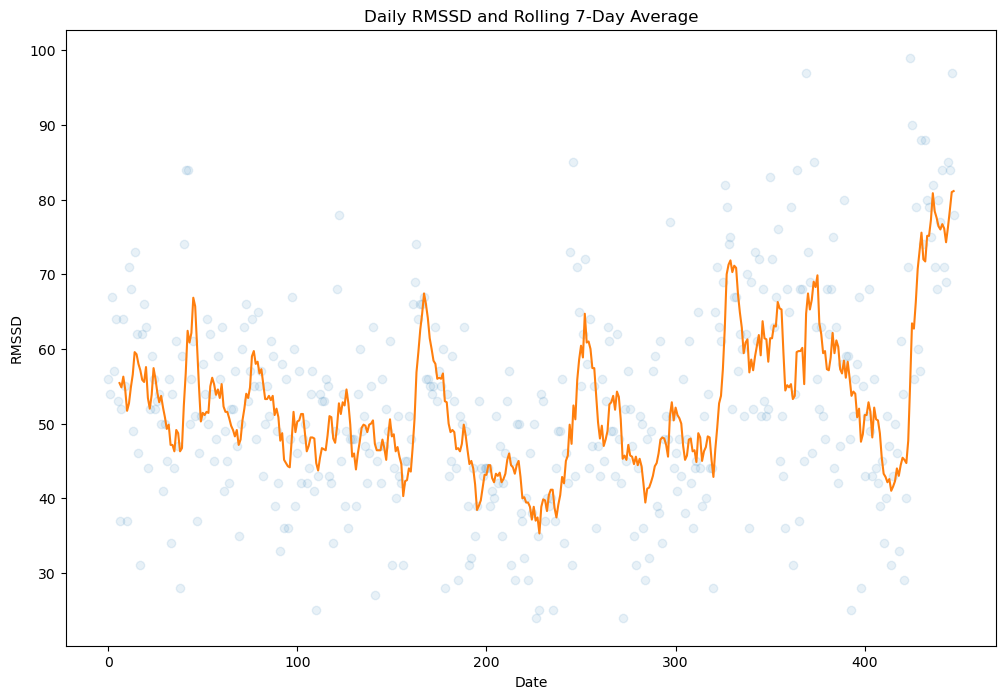

In [14]:
# plot the daily rmssd with a 7-day rolling average overlay
plt.figure(figsize=(12, 8))
plt.plot(oura.rmssd, 'o', alpha=0.1)
plt.plot(oura.rmssd.rolling(7).mean())
plt.title("Daily RMSSD and Rolling 7-Day Average")
plt.xlabel("Date")
plt.ylabel("RMSSD")
plt.show()

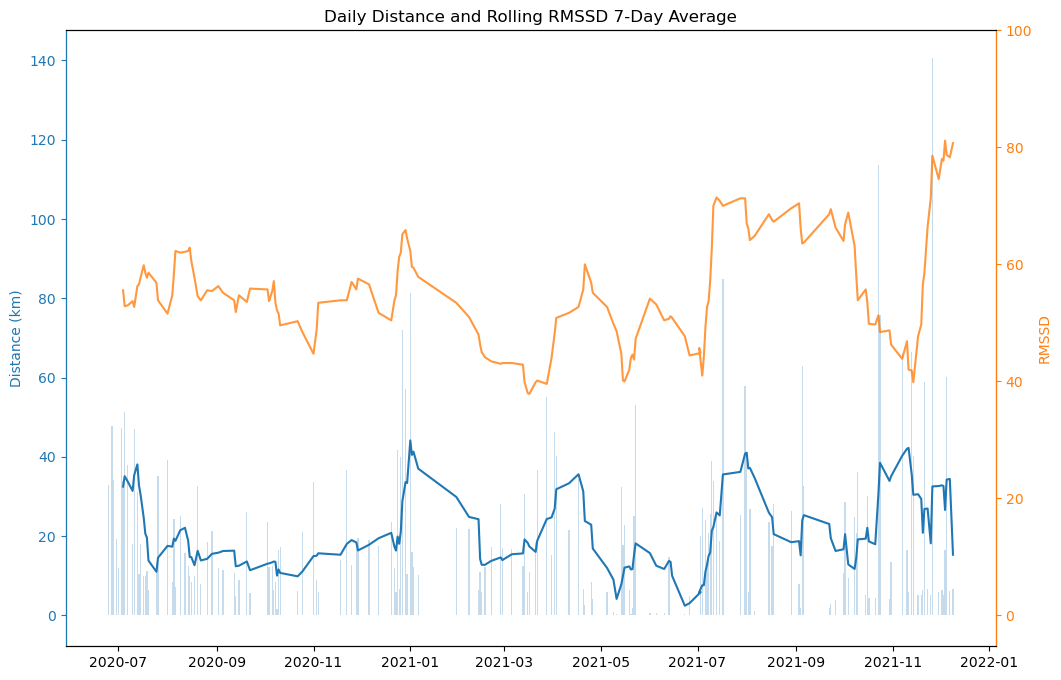

In [15]:
# plot the daily distance, the 7-day rolling average, and the rmssd 7-day rolling average
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(combined_data.date, combined_data.total_dist, alpha=0.25, color='C0')
ax1.plot(combined_data.date, combined_data.total_dist.rolling(7).mean(), color='C0')
ax1.set_ylabel("Distance (km)", color='C0')
ax1.tick_params(axis='y', color='C0', labelcolor='C0')
ax1.set_title("Daily Distance and Rolling RMSSD 7-Day Average")

ax2 = ax1.twinx()
ax2.plot(combined_data.date, combined_data.rmssd.rolling(7).mean(), alpha=0.8,color='C1')
ax2.set_ylabel("RMSSD", color='C1')
ax2.set_ylim(0, 100)
ax2.tick_params(axis='y', color='C1', labelcolor='C1')
ax2.spines['right'].set_color('C1')
ax2.spines['left'].set_color('C0')

org1 = 0.0
org2 = 0.0
pos = 0.05
align.yaxes(ax1, org1, ax2, org2, pos)

plt.show();

In [16]:
# compute the R2 value for distance and rmssd
pearsonr(combined_data.total_dist.rolling(7).mean()[6:], combined_data.rmssd.rolling(7).mean()[6:])

(0.33593909751058215, 5.160499989789703e-06)

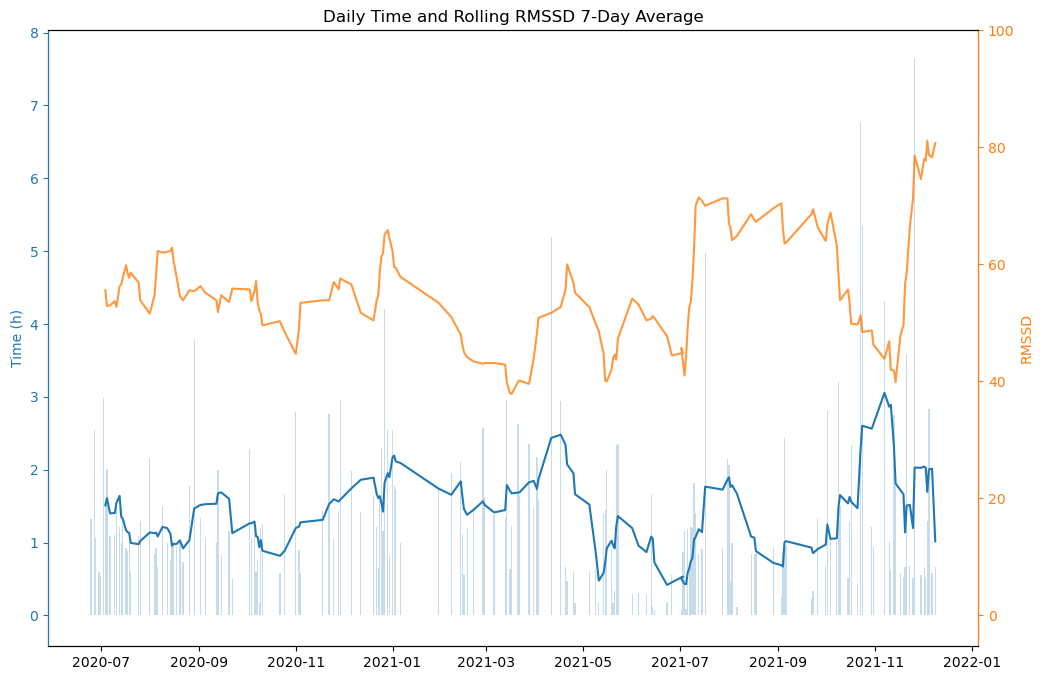

In [17]:
# plot the daily time, the 7-day rolling average, and the rmssd 7-day rolling average
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(combined_data.date, combined_data.total_time, alpha=0.25, color='C0')
ax1.plot(combined_data.date, combined_data.total_time.rolling(7).mean(), color='C0')
ax1.set_ylabel("Time (h)", color='C0')
ax1.tick_params(axis='y', color='C0', labelcolor='C0')
ax1.set_title("Daily Time and Rolling RMSSD 7-Day Average")

ax2 = ax1.twinx()
ax2.plot(combined_data.date, combined_data.rmssd.rolling(7).mean(), alpha=0.8,color='C1')
ax2.set_ylabel("RMSSD", color='C1')
ax2.set_ylim(0, 100)
ax2.tick_params(axis='y', color='C1', labelcolor='C1')
ax2.spines['right'].set_color('C1')
ax2.spines['left'].set_color('C0')

org1 = 0.0
org2 = 0.0
pos = 0.05
align.yaxes(ax1, org1, ax2, org2, pos)

plt.show();

In [18]:
# compute the R2 value for time and rmssd
pearsonr(combined_data.total_time.rolling(7).mean()[6:], combined_data.rmssd.rolling(7).mean()[6:])

(0.008124697612290368, 0.9147730991907984)

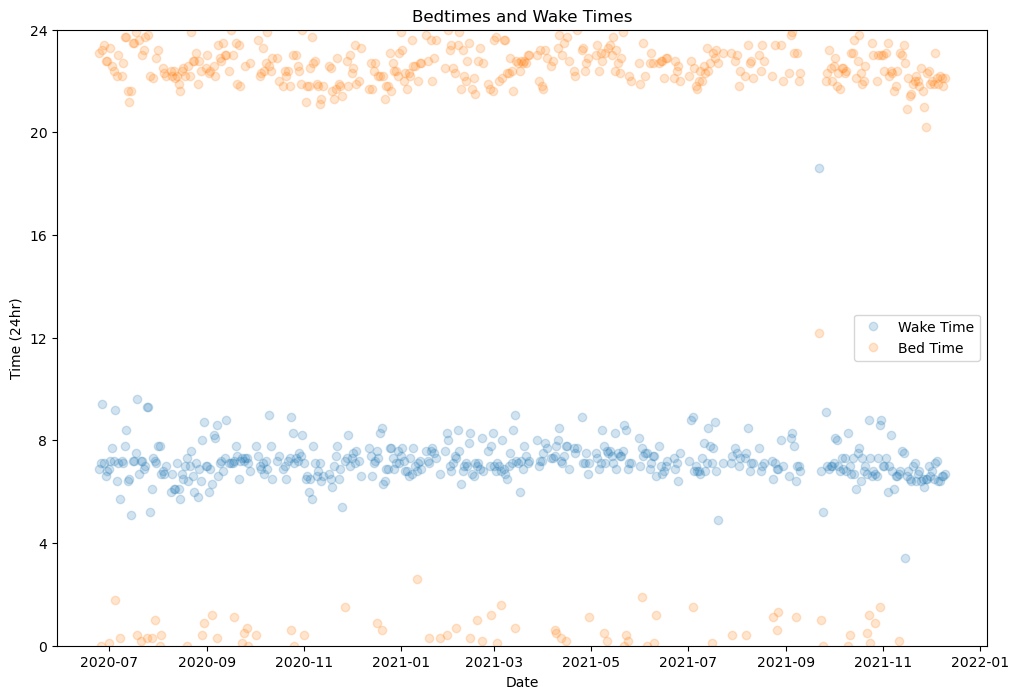

In [19]:
# plot the daily bedtimes and wake times
plt.figure(figsize=(12, 8))
plt.plot(oura.date, oura.wake_time, 'o', alpha=0.2, label="Wake Time")
plt.plot(oura.date, oura.bedtime, 'o', alpha=0.2, label="Bed Time")
plt.ylim(0, 24)
plt.yticks(np.linspace(0, 24, 7))
plt.title("Bedtimes and Wake Times")
plt.xlabel("Date")
plt.ylabel("Time (24hr)")
plt.legend()
plt.show()

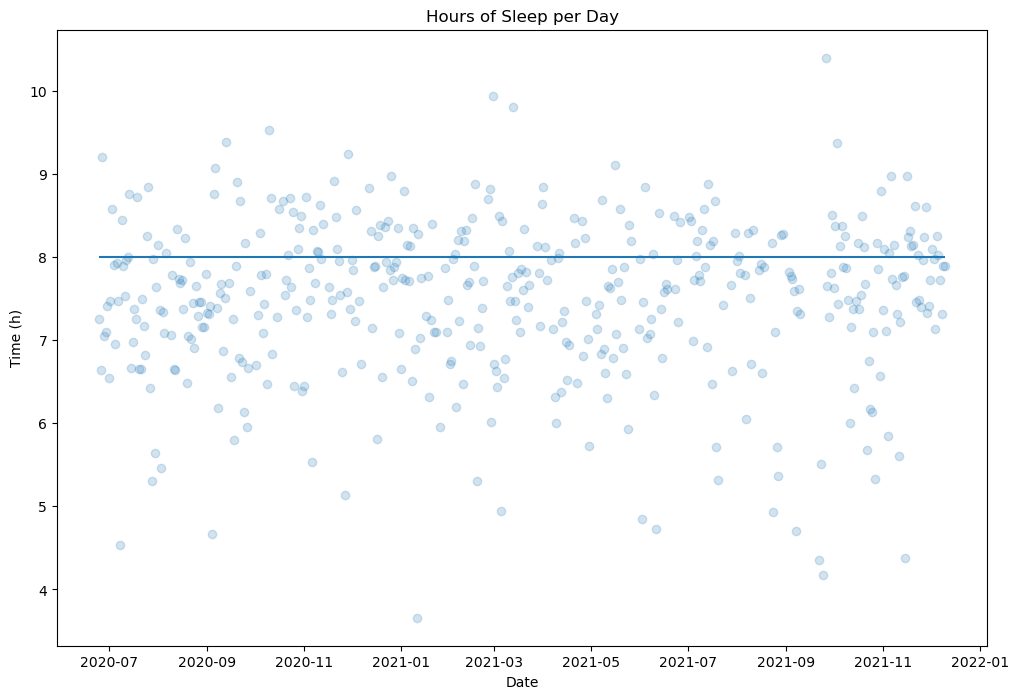

In [20]:
# plot the number of hours of sleep per day with an 8-hour reference line
plt.figure(figsize=(12, 8))
plt.plot(oura.date, oura.total_sleep, 'o', alpha=0.2)
plt.hlines(8, oura.date.min(), oura.date.max())
plt.title("Hours of Sleep per Day")
plt.xlabel("Date")
plt.ylabel("Time (h)")
plt.show()

In [21]:
# calculate the mean and sd for hours of sleep
oura.total_sleep.mean(), oura.total_sleep.std()

(7.495513392857147, 0.9528141316097141)

In [22]:
# count the number of days where the user slept less than 8 hours
sum(oura.total_sleep < 8) / len(oura.total_sleep)

0.703125

Modeling.

In [23]:
# prepare data for modeling
combined_data = combined_data.drop(columns='rpe')
combined_data = combined_data.dropna()
X = combined_data.drop(columns=['date', 'rmssd', 'total_sleep'])
y = combined_data.rmssd

In [39]:
X.shape, y.shape

((151, 17), (151,))

In [24]:
# create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=39)

OLS

In [25]:
# define a custom polynomial regression function
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

# set up a parameter grid for grid search
search_grid = {"polynomialfeatures__degree": np.array([1, 2, 3]),
               "linearregression__fit_intercept": [True, False],
               "linearregression__normalize": [True, False]}
search_grid

# instantiate a GridSearchCV
grid_search = GridSearchCV(PolynomialRegression(), search_grid,
                           cv=5, n_jobs=6,
                           scoring="neg_mean_squared_error")

# conduct a grid search
grid_search.fit(X_train, y_train)

# view the results of our grid search
grid_search.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 1}

In [26]:
# get the predicted y values
ypred = grid_search.best_estimator_.predict(X_test)

# calculate the RMSE and R2
mean_squared_error(y_test, ypred, squared=False), grid_search.best_estimator_.score(X_train, y_train)

(12.703420106587645, 0.5374068688790106)

Standardize the data.

In [27]:
# standardize the training and testing data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

Ridge regression.

In [28]:
# set up a parameter grid for grid search
search_grid = {"alpha": np.logspace(-2, 2, 500),
               "fit_intercept": [True, False]}

# instantiate a Ridge
ridge_reg = Ridge()

# instantiate a GridSearch
grid_search = GridSearchCV(ridge_reg, search_grid,
                           cv=5, n_jobs=6,
                           scoring="neg_mean_squared_error")

# conduct a grid search
grid_search.fit(X_train_std, y_train)

# view the results of our grid search
grid_search.best_params_

{'alpha': 60.75291689016071, 'fit_intercept': True}

In [29]:
# get the predicted y values
ypred = grid_search.best_estimator_.predict(X_test_std)

# calculate the RMSE and the R2 value
mean_squared_error(y_test, ypred, squared=False), grid_search.best_estimator_.score(X_train_std, y_train)

(11.254249294186033, 0.4684157910043836)

LASSO regression.

In [30]:
# set up a parameter grid for grid search
search_grid = {"alpha": np.logspace(-2, 2, 500)}
               #"fit_intercept": [True, False]}

# instantiate a Lasso
lasso_reg = Lasso()

# instantiate a GridSearch
grid_search = GridSearchCV(lasso_reg, search_grid,
                           cv=5, n_jobs=6,
                           scoring="neg_mean_squared_error")

# conduct a grid search
grid_search.fit(X_train_std, y_train)

# view the results of our grid search
grid_search.best_params_

{'alpha': 1.4599186524739787}

In [31]:
# get the predicted y values
ypred = grid_search.best_estimator_.predict(X_test_std)

# calculate the RMSE and the R2 value
mean_squared_error(y_test, ypred, squared=False), grid_search.best_estimator_.score(X_train_std, y_train)

(10.909230083215359, 0.4251539742816395)

Train the optimal model.

In [32]:
# instantiate a Linear regressor with optimal hyperparameters
lin_reg = LinearRegression()

In [33]:
# train the Linear regressor on the full dataset
lin_reg.fit(X, y)

LinearRegression()

In [34]:
# get the R2 value
lin_reg.score(X, y)

0.4975327857695615

Plot the weight of each coefficient to show its affect on RMSSD.

In [35]:
# put the coefficients in a Series with their respective names
coef = pd.Series(lin_reg.coef_, index=X.columns.values)

In [36]:
# sort the values in place, descending
coef.sort_values(ascending=False, inplace=True)

In [37]:
# set plot defaults to seaborn
sns.set()

C:\Users\dlpar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


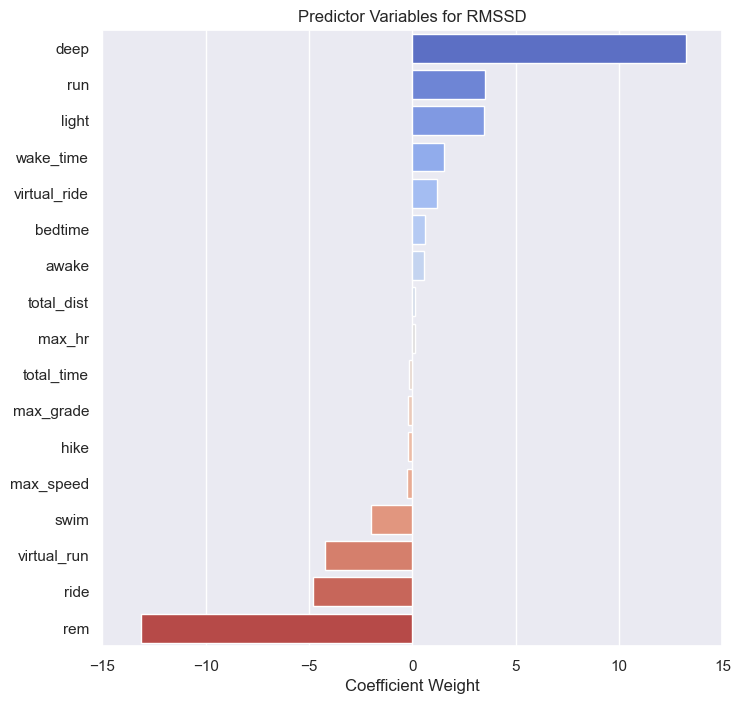

In [38]:
plt.figure(figsize=(8, 8))
sns.barplot(coef.values, coef.index.values, orient="h", palette='coolwarm')
plt.xlabel("Coefficient Weight")
plt.xlim(-15, 15)
plt.title("Predictor Variables for RMSSD")
plt.show()